In [98]:
# Code by: Glenn Weber (glenn.weber@student.maastrichtuniversity.nl)
# 27th of October 2021

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from numpy import loadtxt
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

%store -r X_input_no_outliers
%store -r X_pca_no_outliers

In [99]:
## function

def plot_roc_curve(fper, tper):
    plt.plot(fper, tper, color='red', label='ROC, AUC = %.2f'%auc)
    plt.plot([0, 1], [0, 1], color='green', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend()
    plt.show()
    plt.savefig('output/ROC.png')

In [100]:
# scale input variables, use integer values
X_no_outliers = X_input_no_outliers
scaler = StandardScaler()
scaler.fit(X_no_outliers)
X = (scaler.transform(X_no_outliers) * 100).astype(int)

# select pc1: non outlier, split into below mean (0) and above mean (1)
y_no_outliers = np.array(X_pca_no_outliers[0])
y = (pd.Series(y_no_outliers) < np.mean(y_no_outliers)).astype(int)

In [101]:
# split data into training data (0-2000) and testing (2000-2200)
X_train = np.array(X)[:2000,:].astype(int)
y_train = np.array(y)[:2000]

X_test = np.array(X)[2000:,:].astype(int)
y_test = np.array(y)[2000:]

In [102]:
# define the keras model
model = Sequential()
model.add(Dense(12, input_dim=21, activation='relu'))
model.add(Dense(14, activation='relu'))
model.add(Dense(12, activation='selu'))
model.add(Dense(12, activation='selu'))
model.add(Dense(14, activation='relu'))
model.add(Dense(1, activation='hard_sigmoid'))
# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit the keras model on the dataset
model.fit(X_train, y_train, epochs=150, batch_size=10)
# evaluate the keras model
_, accuracy = model.evaluate(X_train, y_train)
print('Accuracy: %.2f' % (accuracy*100))

Epoch 1/150
200/200 [==============================] - 1s 1ms/step - loss: 6.2509 - accuracy: 0.5180
Epoch 2/150
200/200 [==============================] - 0s 1ms/step - loss: 5.7877 - accuracy: 0.5565
Epoch 3/150
200/200 [==============================] - 0s 1ms/step - loss: 4.7234 - accuracy: 0.5835
Epoch 4/150
200/200 [==============================] - 0s 858us/step - loss: 3.8809 - accuracy: 0.5695
Epoch 5/150
200/200 [==============================] - 0s 844us/step - loss: 2.6346 - accuracy: 0.5625
Epoch 6/150
200/200 [==============================] - 0s 935us/step - loss: 1.7608 - accuracy: 0.5755
Epoch 7/150
200/200 [==============================] - 0s 875us/step - loss: 1.8573 - accuracy: 0.5400
Epoch 8/150
200/200 [==============================] - 0s 1ms/step - loss: 1.9030 - accuracy: 0.5340
Epoch 9/150
200/200 [==============================] - 0s 982us/step - loss: 1.5758 - accuracy: 0.5410
Epoch 10/150
200/200 [==============================] - 0s 976us/step - loss: 1.1

In [103]:
# Make predictions for test input
scores = [i[0] for i in model.predict(X_test)]

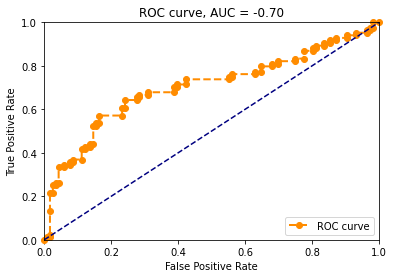

In [104]:
# Make a plot of Area under curve (that can be exported to a png file)
fpr, tpr, thresholds = metrics.roc_curve(y_test, scores, pos_label=1)
auc = -1 * np.trapz(tpr, fpr)
plt.plot(fpr, tpr, linestyle='--', marker='o', color='darkorange', lw = 2, label='ROC curve', clip_on=False)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve, AUC = %.2f'%auc)
plt.legend(loc="lower right")
plt.savefig('output/ROC.png')
plt.show()

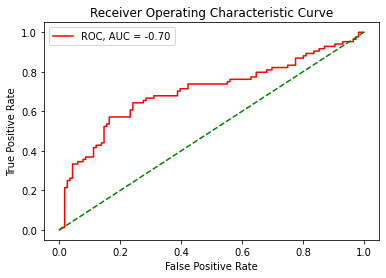

<Figure size 432x288 with 0 Axes>

In [105]:
# Create a more appealing version of the AUC curve plot
metrics.auc(fpr, tpr)
plot_roc_curve(fpr, tpr)

/Users/glennweber/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


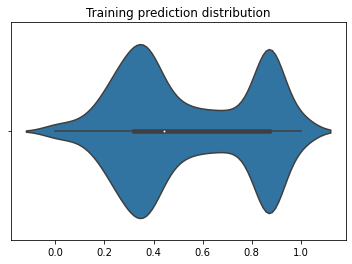

In [106]:
# Plot the distribution of the predictions made from the training input
sns.violinplot(model.predict(X_train)).set(title='Training prediction distribution')
plt.savefig('output/tr_pred_dist.png')

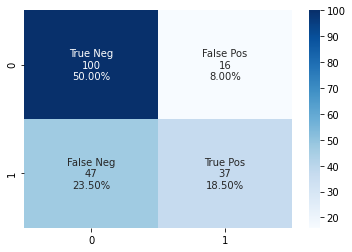

In [107]:
# Make a confusion matrix (how many false positives, true negatives, etc.)
cf_matrix = metrics.confusion_matrix(y_test, (scores > np.mean(scores)).astype(int))
cf_matrix / 100

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
plt.savefig('output/cf_matrix.png')